From paper: https://arxiv.org/pdf/2306.07736.pdf

<h1>5. Simulations Study</h1>

We generate $W_1,...,W_n$ as an independent bivariate normal random vectors with mean zero and unit variance and correlation 0.5.

Given $W$, we draw $A_1,...,A_n$ from the conditional distribution with density function

$$
g_0(a|w) = \frac{\text{expit}(\zeta(w)a)}{\int_{-1}^1\text{expit}(\zeta(w)a)da}\mathbb{I}(-1\leq a \leq 1)
$$

$$
\zeta(w) = 3 \bigg\{  \text{expit}(w_1+w_2)- \frac{1}{2} \bigg\}
$$
$$
Y = -\zeta(W)\bigg\{1-\frac{A}{2}\bigg\} + \epsilon
$$

Case Study B is such that:

$$
\theta_0 : a \mapsto \frac{2a + a^2  - a^3}{2} \\
Y = \theta_0(A) - \zeta(W)\big\{1 - \frac{A}{2} \big\} + \epsilon
$$

In [1]:
library(rje)
library(MASS)

bivariate_normal <- function(n){
    mu <- c(0, 0)
    sigma <- matrix(c(1, 0.5, 0.5, 1), nrow = 2, ncol = 2)
    return(mvrnorm(n, mu, sigma))
}

zeta <- function(w){
    return(3*(expit(w[1] + w[2]) - 0.5))
}

indicate <- function(a){
   ifelse(a > 1 | a < -1, 0, 1)
}

# define function for g0
g0 <- function(a, w) {
    expit(zeta(w)*a) / integrate(function(x) expit(zeta(w)*x), -1, 1)$value * indicate(a)
}

theta_0_fn <- function(a){
    (2*a + a*a - (a*a*a)) / 2
}

n <- 30
W <- bivariate_normal(n)
# generate A using inverse CDF method
A <- numeric(n)
for (i in 1:n) {
    u <- runif(1)
    f <- function(a) integrate(function(x) g0(x, W[i,]), -1, a)$value - u
    A[i] <- uniroot(f, c(-1, 1))$root
}

Y <- numeric(n)
for (i in 1:n) {
    epsilon <- runif(1, -2, 2)
    z = zeta(W[i,])
    # Case A
    Y[i] <- -z * (1 - (A[i] / 2)) + epsilon
    # Case B
    # Y[i] <- theta_0_fn(A[i]) - (z * (1 - (A[i]/2))) + epsilon
}


data <- as.data.frame(cbind(W, A, Y))
colnames(data) <- c("W1","W2","A","Y")
head(data)

,W1,W2,A,Y
,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.2800004,-1.180371470,-0.8630398,1.1476221
2,0.6915074,0.934970290,0.1675308,-2.4621969
3,-1.8221066,-1.915360020,-0.3561725,2.4112679
4,0.6018957,-0.003221373,0.7282529,-1.8264537
5,1.2991551,1.590090239,0.9820966,-1.1335363
6,0.2432559,0.228652050,-0.8236068,0.9997091


It is constructed as such that $\theta_0$ (mean centered) = 0. There is no 'curve', therefore one would expect $E[Y] = 0$

In [2]:
mean(sapply(1:n, function(i) zeta(W[i, ])))
print(mean(data[, 3]))
print(mean(data[, 4]))

[1] 0.2063058

[1] 0.1242012
[1] -0.02105278


<h1>Plug in Estimator</h1>
The plug-in estimator for h is

$$
\psi_{\hat P_n, \theta^*}(h) = n^{-1}\sum_{i=1}^n\bigg[\theta_n(A_i) - \theta^*(A_i) - n^{-1}\sum_{j=1}^n\theta_n(A_j -\theta^*(A_j))\bigg]h(A_i) 
$$

Where the plug-in estimator for the dose response function is
$$
\theta_n : a \mapsto n^{-1}\sum_{i=1}^nQ_n(a, W_i)
$$

<h2>Sjoerd</h2>
Hal Estimate doesn't use treatment as a factor?

In [3]:
library(sl3)

# fast highly adaptive lasso (HAL) implementation
# Turns out this sucks at the regression? And also does pay any attention to A?
lrn_hal <- Lrnr_hal9001$new(max_degree = 2, num_knots = c(3,2))
lrn_glm <- Lrnr_glm$new()

regression_Qn <- make_sl3_Task(
  data = data,
  outcome = "Y",
  covariates = c("W1","W2","A")
)

hal_fit <- lrn_hal$train(task=regression_Qn)
Qn_fit <- lrn_glm$train(task=regression_Qn)

In [14]:
summary(lrn_hal)

ERROR: Error in object[[i]]: wrong arguments for subsetting an environment


In [12]:
hal_fit$params

$max_degree
[1] 2

$num_knots
[1] 3 2

$covariates
[1] "W1" "W2" "A"

In [5]:
Qn_fit

[1] "Lrnr_glm_TRUE"
$coefficients
 intercept         W1         W2          A 
 0.1341525 -0.9722202  0.1061680 -0.3669019 

$R
          intercept         W1        W2          A
intercept -5.477226 -0.7388918 -1.110188 -0.6802782
W1         0.000000 -5.7408040 -3.606533 -1.1848921
W2         0.000000  0.0000000  3.859403  0.7640043
A          0.000000  0.0000000  0.000000 -3.1268232

$rank
[1] 4

$family

Family: gaussian 
Link function: identity 


$deviance
[1] 30.14337

$aic
[1] 95.27934

$null.deviance
[1] 63.20884

$iter
[1] 2

$df.residual
[1] 26

$df.null
[1] 29

$converged
[1] TRUE

$boundary
[1] FALSE

$linkinv_fun
function (eta) 
eta
<environment: namespace:stats>

$link_fun
function (mu) 
mu
<environment: namespace:stats>

$training_offset
[1] FALSE


To construct a nonparametric estimator for the conditional estimator function $g_0$ is a little trickier. I think we can use haldensify? Seemingly the Haldensify doesn't really return a coherent answer. 
<br>
Below is from:
https://tlverse.org/tlverse-handbook/sl3.html#conditional-density-estimation

In [16]:
# semiparametric density estimator with homoscedastic errors (HOSE)
hose_hal_lrnr <- Lrnr_density_semiparametric$new(
    mean_learner = Lrnr_hal9001$new()
)
# semiparametric density estimator with heteroscedastic errors (HESE)
hese_rf_glm_lrnr <- Lrnr_density_semiparametric$new(
    mean_learner = Lrnr_ranger$new(),
    var_learner = Lrnr_glm$new()
)

# SL for the conditional treatment density
sl_dens_lrnr <- Lrnr_sl$new(
    learners = list(hose_hal_lrnr, hese_rf_glm_lrnr),
    metalearner = Lrnr_solnp_density$new()
)

cde_task <- make_sl3_Task(
  data = data,
  outcome = "A",
  covariates = c("W1","W2")
)

g0_fit <- sl_dens_lrnr$train(cde_task)


Iter: 1 fn: 25.6977	 Pars:  0.990272 0.009728
Iter: 2 fn: 25.6977	 Pars:  0.990274 0.009726
solnp--> Completed in 2 iterations


<strong> Sjoerd </strong> Likelihood is greater than 1? Or maybe not?

In [17]:
g0_fit$predict(cde_task)

$likelihood
 [1] 0.6642364 0.4822365 0.5914772 0.6399936 0.5462653 0.4053089 0.3903794
 [8] 0.2114169 0.6429891 0.5843358 0.5964557 0.2939538 0.6488396 0.3287138
[15] 0.6735436 0.5897848 0.5747639 0.6644179 0.5875494 0.5512342 0.5314233
[22] 0.5637871 0.3684040 0.6072384 0.5850844 0.5599931 0.6760506 0.6589153
[29] 0.6409613 0.2353236

attr(,".internal.selfref")
<pointer: 0x12400d0e0>

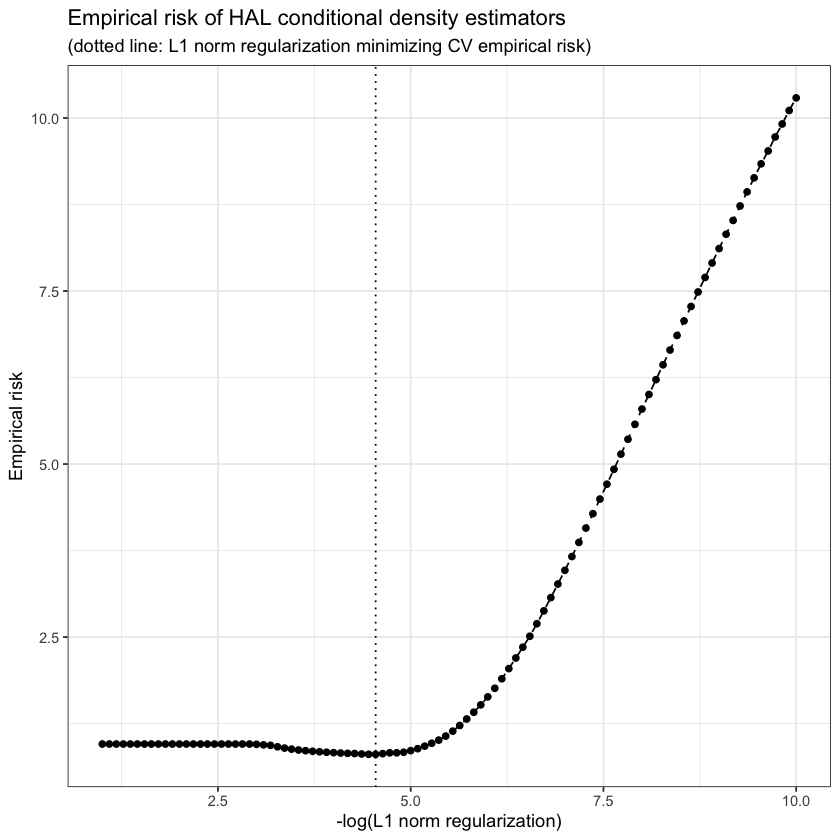

In [37]:
library(haldensify)

g0_fit <- haldensify(
  A = data$"A", W = c(data$"W1", data$"W2"),
  n_bins = c(5,10), grid_type = "equal_range",
  lambda_seq = exp(seq(-1, -10, length = 100)),
  # arguments passed to hal9001::fit_hal()
  max_degree = 3,
  reduce_basis = 1 / sqrt(n)
)

plot(g0_fit)

In [38]:
predict(g0_fit, new_A=cde_task$data$A, new_W=cde_task$data[,c("W1","W2")])

[1] 0.5034448 0.5871091 0.9462306 0.5783556 0.4774998 0.6720093 0.6720093
 [8] 0.6720093 0.5783556 0.5034448 0.6764078 0.2683969 0.7721270 0.2936326
[15] 0.5867544 0.7062900 0.4774998 0.4150786 0.7276084 0.3320194 0.4150786
[22] 0.7417324 0.2936326 0.4150786 0.7062900 0.7062900 0.5867544 0.7636603
[29] 0.5867544 0.2936326

In [28]:
permute_data <- function(a, w = NULL){
    copy <- data
    copy$A <- a
    if (!is.null(w)){
        copy$W1 <- w[[1]]
        copy$W2 <- w[[2]]
    }
    return(copy)
}

qn_prediction_treatment <- function(a){
    task <- make_sl3_Task(
        data = permute_data(a),
        covariates = c("W1","W2","A")
    )
}

qn_prediction_counterfactual <- function(w, a){
    task <- make_sl3_Task(
        data = permute_data(a, w),
        covariates = c("W1","W2","A")
    )
}

In [29]:
dose_response_estimator <- function(a) {
    pred_task <- qn_prediction_treatment(a)
    theta = mean(Qn_fit$predict(pred_task))
    return(theta)
}

naive_psi_inner_product_estimator <- function(h) {
    k <- numeric(n)
    for(i in 1:n){
        theta <- dose_response_estimator(A[i]) 
        j_sum <- sapply(1:n, function(j) dose_response_estimator(A[j])) 
        k[i] = (theta - 0 - mean(j_sum)) * h(A[i])
    }
    return(mean(k))
}

naive_psi_inner_product_estimator(function(x) 3) # This is surprisingly right given n=10, we're drawing from Y such that mean centered dose response is 0?

[1] -8.881784e-17

In [45]:
dose_response_estimator(-0.4)

[1] 0.1977196

<h1>Efficient Influence Function</h1>
Equation 15 in paper

$$
\phi_{n,\theta^*}(w, a, y; h) = \bigg[
    \frac{n^{-1}\sum_{i=1}^n g_n(a|W_i)}{g_n(a|w)}
    {y - Q_n(w,a)}
\bigg]
\bigg\{
h(a) - n^{-1}\sum_{i=1}^nh(A_i)
\bigg\}+\\
n^{-1}\sum_{i=1}^nQ_n(w,A_i)\bigg\{
h(A_i)-n^{-1}\sum_{j=1}^nh(A_j)
\bigg\}-\\
n^{-1}\sum_{i=1}^n\{Y_i-Q_n(W_i,A_i)\}Z_n(W_i,A_i; h)
$$

Where $\theta_n$ is the plug in estimator the dose response function and 

$$
Z_n(w, a; h) := \frac{n^{-1}\sum_{i=1}^ng_n(a|W_i)}{g_n(a|w)}\bigg\{ h(a)-n^{-1}\sum_{i=1}^nh(A_i)
    \bigg\}
$$

<h2>Sjoerd</h2> It predicts the same 

In [34]:
A <- c(0.24, 0.6, -0.15)
W1 <- c(-0.1, -0.3, 0.12)
W2 <- c(0.24, -0.1, 0.15)
df <- data.frame(A, W1, W2)
df

A,W1,W2
<dbl>,<dbl>,<dbl>
0.24,-0.10,0.24
0.60,-0.30,-0.10
-0.15,0.12,0.15


In [35]:
predict(g0_fit, new_A = df$A, new_W= df[,c("W1","W2")])

[1] 2.627634 2.627634 2.627634

<h2>Sjoerd</h2> By nature of the above predicting the same CDE the below equations then make no sense, see below same value for all inputs.

In [39]:
zn_equation <- function(w, a, h){
    a <- numeric(n) + a
    A <- data[,"A"]
    W <- data[,c("W1","W2")]

    # Haldenisfy prediction seem way off... TODO: Check Haldensify
    # Why the denominator repeat then take avg? Haldensify won't predict for dim(1)...
    first_term <- mean(predict(g0_fit, new_A = a, new_W = W)) / mean(predict(g0_fit, new_A = a, new_W = w))
    print(first_term)

    second_term <- h(a) - mean(sapply(1:n, function (i) h(A[i])))
    return((first_term * second_term))
}

zn_equation(c(0.1, 0.2), 0.1, function(x) x)

[1] 1.056917


[1] 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969
 [7] 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969
[13] 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969
[19] 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969
[25] 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969 0.08729969

In [40]:
efficient_influence_function <- function(w, a, y, h){
    A <- data[,"A"]
    W <- data[,c("W1","W2")]
    Y <- data[,"Y"]

    first_line_term1 <- (mean(predict(g0_fit, new_A = A, new_W = W)) / mean(predict(g0_fit, new_A = c(a, a), new_W = c(w, w))) * y ) - mean(Qn_fit$predict(qn_prediction_counterfactual(w, a)))
    first_line_term2 <- h(a) - mean(sapply(1:n, function (i) h(A[i])))
    first_line <- first_line_term1 * first_line_term2

    second_line <- numeric(n)
    for(i in 1:n){
        second_line[i] <- mean(Qn_fit$predict(qn_prediction_counterfactual(w, A[i]))) * (h(A[i]) - mean(sapply(1:n, function(j) h(A[j]))))
    }
    second_line <- mean(second_line)

    third_line <- numeric(n)
    for(i in 1:n){
        third_line[i] <- (Y[i] - mean(Qn_fit$predict(qn_prediction_counterfactual(W[i, ], A[i])))) * zn_equation(W[i, ], A[i], h)
    }
    third_line <- mean(third_line)

    first_line + second_line - third_line
}

efficient_influence_function(c(0.1,0.2), 0.5, 0.2, dose_response_estimator)

[1] 1.051018
[1] 0.8072837
[1] 1.040155
[1] 1.042266
[1] 1.065119
[1] 0.7905902
[1] 0.7905902
[1] 0.7905902
[1] 1.042266
[1] 1.051018
[1] 1.036409
[1] 1.043878
[1] 1.056287
[1] 1.040616
[1] 1.045194
[1] 1.0516
[1] 1.065119
[1] 1.065657
[1] 1.050573
[1] 1.074543
[1] 1.065657
[1] 1.047098
[1] 1.040616
[1] 1.065657
[1] 1.0516
[1] 1.0516
[1] 1.045194
[1] 1.056686
[1] 1.045194
[1] 1.040616


[1] 0.05553722

In [205]:
library(testthat)

# test_that("EIC Works", {
#     w <- c(1, 2, 3)
#     a <- c(0, 1, 1)
#     y <- c(1, 2, 3)
#     h <- function(x) {x * x}
#     EIC_computed <- efficient_influence_function(w, a, y, h)
#     EIC_expected <- c(2, 4, 6)
# 
#     expect_equal(EIC_computed, EIC_expected)
# })

<h1>Construction of H</h1>

Retrospect: I Think I may have defined these slightly wrong. Is $\eta_d : a \mapsto \sqrt{n}sin(\pi d a)$?

$$
\eta_{2d-1} : a \mapsto \sqrt{2}\cos (2\pi d a)\\
\eta_{2d} : a \mapsto \sqrt{2}\sin (2\pi d a) \\
\gamma_{2d-1} = \gamma_{2d} = (2\pi d )^{-4}
$$

For implementation reasons defining $\eta$ is a lot easier, even if it's cumbersome to do so in R.

In [46]:
setClass("eta",
    slots = c(
        d = "numeric"
    ), 
    prototype = list(
        d = 1
    )
)

# Define the "calculate" method for the "eta" class
setGeneric("run", function(object, a) standardGeneric("run"))

setMethod("run", "eta", function(object, a){
    if (object@d %% 2 == 0) {
        return(sqrt(2) * sin(pi * object@d * a))
    } else {
        return(sqrt(2) * cos(pi * object@d * a))
    }
})

[1] "run"

In [47]:
D <- 5
D_vector <- seq(1, D)

gamma_fn <- function(d){
    (pi * d)^(-4)
}

c <- numeric(D)

gamma <- gamma_fn(D_vector)
gamma_matrix <- diag(1 / gamma) # These numbers seem awfully large? 
gamma_matrix

97.40909,0.000,0.000,0.00,0.00
0.00000,1558.545,0.000,0.00,0.00
0.00000,0.000,7890.136,0.00,0.00
0.00000,0.000,0.000,24936.73,0.00
0.00000,0.000,0.000,0.00,60880.68


For now we'll use $\psi_{n, \theta^*}(\eta_d)$ using the naive plug in estimator. As $\eta_d$ is eigenfunction decomopistion of function $h$. We define for any $h$

$$
\psi_n(h)= \sum_{d=1}^Dc_d\psi_n(\eta_d)

$$

V is a $D\times D$ matrix, as I think can be seen as the covariance matrix between $(d_1, d_2)$

$$
V_{d_1,d_2}= n^{-1}\sum_{i=1}^n \bigg\{ 
    \eta_{d_1}(A_i)-n^{-1}\sum_{j=1}^n\eta_{d_1}A(j)
\bigg\}
\bigg\{ 
    \eta_{d_2}(A_i)-n^{-1}\sum_{j=1}^n\eta_{d_2}A(j)
\bigg\}
$$

<h2>Sjoerd</h2>

Visualisation of $U(\theta^*)^T\bold c$
$$
\underbrace{
\begin{bmatrix}
\psi(\eta_1)\\
\psi(\eta_2)\\
... \\
\psi(\eta_D)
\end{bmatrix}}_{U^{(m)}} \cdot \begin{bmatrix}
c_1 & c_2 & ... & c_D
\end{bmatrix} \\

V = \begin{bmatrix}
\text{cov}(\eta_1,\eta_1) & . & . & \text{cov}(\eta_1,\eta_D) \\
& & & .\\
& & & .\\
& & & \text{cov}(\eta_D,\eta_D)
\end{bmatrix},

\Gamma = \begin{bmatrix}
\frac{1}{\gamma_1} \\
& \frac{1}{\gamma_2} \\
& & ... \\
& & & \frac{1}{\gamma_d}
\end{bmatrix},
$$



In [49]:
# Sum j -> n 
second_term_fn <- function(A, d){
    agg <- numeric(n)
    eta <- new("eta", d = d)
    for(j in 1:n){
        run(eta, A[j])
    }
    return(mean(agg))
}

v_elem <- function(d1, d2){
    A = data[,"A"]
    agg <- numeric(n)
    eta_d1 <- new("eta", d = d1) 
    eta_d2 <- new("eta", d = d2)
    for (i in 1:n){
        d1_bracket <- run(eta_d1, A[i]) - second_term_fn(A, d1) 
        d2_bracket <- run(eta_d2, A[i]) - second_term_fn(A, d2)
        agg[i] <- d1_bracket * d2_bracket
    }
    return(mean(agg))
}


V <- matrix(0, nrow = D, ncol = D)
for (l in 1:D){
    V[l, ] <- sapply(1:D, function(k) v_elem(l, k)) # Slightly wasteful could leverage symmetry
}

V

0.984370480,-0.02382287,-0.04458552,-0.08060779,-0.009338828
-0.023822869,1.02895600,-0.05678492,-0.03524670,0.047930377
-0.044585524,-0.05678492,1.01961718,0.02410751,0.125834281
-0.080607794,-0.03524670,0.02410751,0.85853620,0.003864550
-0.009338828,0.04793038,0.12583428,0.00386455,1.238647759


We can express eigendecompistion sum as a vector product $U^Tc$

We can therefore optimise for $\bold c_n$
(<em>What is meant by less than $\gamma$, it's a vector but is being treated like a scalar?</em>
$$
    \bold c_n := \arg \max \big\{ U(\theta^*)^Tc: c^TVc=1, c^T\Gamma c \leq \gamma \big\}
$$

We first define $U(\theta^*)$
$$
    \begin{bmatrix}
        \psi(\eta_1) & \psi(\eta_2) & ... & \psi(\eta_D)
    \end{bmatrix}
$$

NB: We redefine the estimator to handle the eta class, instead of a typical functional. These next two cells could become very expensive to run.

In [263]:
naive_psi_inner_product_estimator <- function(eta) {
    k <- numeric(n)
    for(i in 1:n){
        theta <- dose_response_estimator(A[i]) 
        j_sum <- sapply(1:n, function(j) dose_response_estimator(A[j])) 
        k[i] = (theta - 0 - mean(j_sum)) * run(eta, A[i]) # Replaces h(A[i])
    }
    return(mean(k))
}

In [290]:
U <- sapply(1:D, function(d) naive_psi_inner_product_estimator(new("eta", d=d)))
U

[1]  0.01473942 -0.15702988  0.07986294 -0.04332089  0.05115494

Using the KKT conditions the Lagrange multipliers are defined as 

Where $\lambda_{2,n}$ satisfies:
$$
\frac{
    U(\theta^*)^T(V+\lambda_{2,n}\Gamma)^{-1}\Gamma(V+\lambda_{2,n}\Gamma)^{-1}U(\theta^*)
}{
    U(\theta^*)^T(V+\lambda_{2,n}\Gamma)^{-1}V(V+\lambda_{2,n}\Gamma)^{-1}U(\theta^*)
}=\gamma
$$

and 
$$
    \lambda_{1,n} = \bigg\{ U(\theta^*)^T(V+\lambda_{2,n}\Gamma)^{-1}V(V+\lambda_{2,n}\Gamma)^{-1}U(\theta^*)\bigg\}^{1/2}
$$

In [291]:
lambda_2_eq <- function(lambda){
    inv_term <- solve(V + lambda * gamma_matrix)
    numerator <- t(U) %*% inv_term %*% gamma_matrix %*% inv_term %*% U
    denominator <- t(U) %*% inv_term %*% V %*% inv_term %*% U
    return((numerator) - gamma[1]) # This is Wrong!!!
}

lambda_2 <- uniroot(lambda_2_eq, interval = c(0, 100))$root
print(lambda_2)

lambda_1_inv_term <- solve(V + lambda_2 * gamma_matrix)
lambda_1 <- sqrt(t(U) %*% lambda_1_inv_term %*% V %*% lambda_1_inv_term %*% U)

print(lambda_1)

[1] 0.04159561
            [,1]
[1,] 0.003696956


We then express $\Psi_n(\mathcal{H}_\kappa)$ as

$$
\Psi_{n,\theta^*}(\mathcal{H}_\kappa)=\lambda^{-1}_{1,n}U(\theta^*)^T(V+\lambda_{2,n}\Gamma)^{-1}U(\theta^*)
$$

In [266]:
Psi <- (1/lambda_1) * t(U) %*% lambda_1_inv_term %*% U
Psi

0.1190453


<h2>Bootstrap Approximation</h2>

The above but with a distribution of $U^{(m)}$


For $m = 1, ..., M$ where $M$ is large, we draw $\xi_1^{(m)},...,\xi_n^{(m)}$, as independent standard normal variables.

Let $\bar \xi^{(m)} = n^{-1}\sum_{i=1}^n\xi_i^{(m)}$

In [345]:
M <- 3
xi <- sapply(1:n, function(i) rnorm(M))
print(dim(xi)) # M x N matrix, each row is a xi_m

bar_xi <- rowMeans(xi)
print(length(bar_xi))

m <- 1


[1]  3 30
[1] 3


[1] -0.47401312  1.53201000 -0.93215369 -0.18919273  2.23930188  0.50642101
 [7] -0.88289424  0.73760411  0.76980463 -0.74064076  0.45141885  1.27982660
[13]  2.08187229  0.93410747 -0.84408612  0.64709853  0.14063826  0.53448751
[19] -1.20547177  0.06903299  1.49165929 -0.89456292  0.20092700 -1.56501075
[25]  0.90198682 -2.01603364 -0.71489007 -1.10483478 -2.17364215 -0.78077052

Let $U^{(m)}$ be a D-dimensional vector with the $d$-th being 

$$
    U_d^{(m)} = n^{-1}\sum_{i=1}^{n}\big(\xi_i^{(m)}- \bar \xi ^{(m)}\big)\phi_{n,\theta^*}(O_i, \eta_d)
$$

where $\phi$ is the plug-in estimator for the efficient influence function.

In [282]:
i <- 1
print(efficient_influence_function(as.numeric(data[i, c(1,2)]), data[i, 3], data[i, 4], function(x) run(new("eta", d = 2), x)))

print(efficient_influence_function(as.numeric(data[i, c(1,2)]), data[i, 3], data[i, 4], function(x) run(new("eta", d = 10), x)))


[1] -0.2472345
[1] -0.4194831


In [332]:
eif_fn <- function(i, d){
    eif <- efficient_influence_function(c(data$W1[i], data$W2[i]), data$A[i], data$Y[i], function(x) run(new("eta", d=d), x))
    eif
}

In [348]:
# U should be a M x D data structure
U <- data.frame(matrix(NA, nrow=M, ncol=D))
for (m in 1:M){
    for (d in 1:D){
        U[m, d] <- mean(sapply(1:n, function(i) (xi[m, i] - bar_xi) * eif_fn(i, d)))
    }
}

In [347]:
U

X1,X2,X3,X4,X5
<lgl>,<dbl>,<lgl>,<lgl>,<lgl>
NA,3,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA
NA,NA,NA,NA,NA


In [292]:
# data[i, ...] <- (w, a, y)

U <- numeric(D)
for (d in 1:D){
    U[d] <- mean(sapply(1:n, function(i) (xi[i ,] - bar_xi) * efficient_influence_function(as.numeric(data[i, c(1,2)]), data[i, 3], data[i, 4], function(x) run(new("eta", d = i), x))))
}
U

[1] 0.01275243 0.01275243 0.01275243 0.01275243 0.01275243

The $m$-th sample, from the multiplier bootstrap estimate of the null distribution can be calculated as 

$$
 \Psi_{n, \theta^*}^{(m)}(\mathcal{H}_{\kappa}) = \sup_{c \in \R^d}\bigg\{ \bigg(U^{(m)} \bigg)^T \bold c: \bold c^T\Gamma \bold c \leq \gamma, \bold c ^T V \bold c =1 \bigg\}
$$

We solve this optimisation problem by the same way as before...

In [299]:
U

[1] 0.01275243 0.01275243 0.01275243 0.01275243 0.01275243

In [302]:
solve_U_m <- function(U){
    lambda_2_eq <- function(lambda){
        inv_term <- solve(V + lambda * gamma_matrix)
        numerator <- t(U) %*% inv_term %*% gamma_matrix %*% inv_term %*% U
        denominator <- t(U) %*% inv_term %*% V %*% inv_term %*% U
        return((numerator) - gamma[1]) # This is Wrong!!! # What is meant by just gamma
    }

    lambda_2 <- uniroot(lambda_2_eq, interval = c(0, 100))$root

    lambda_1_inv_term <- solve(V + lambda_2 * gamma_matrix)
    lambda_1 <- sqrt(t(U) %*% lambda_1_inv_term %*% V %*% lambda_1_inv_term %*% U)

    Psi <- (1/lambda_1) * t(U) %*% lambda_1_inv_term %*% U
    Psi
}

Psi <- numeric(M)
for (m in 1:M){
    Psi[m] <- solve_U_m(U)
}

Psi

[1] 0.01410994 0.01410994 0.01410994 0.01410994 0.01410994 0.01410994
 [7] 0.01410994 0.01410994 0.01410994 0.01410994 0.01410994 0.01410994
[13] 0.01410994 0.01410994 0.01410994

$$
\rho_M(t) = M^{-1}\sum_{m=1}^M 1 (\Psi^{(m)}_{n,\theta^*}(\mathcal{H}_\kappa) > t)
$$

In [304]:
rho_t <- function(t){
    mean(sapply(1:M, function(m) ifelse(Psi[m] > t,1, 0)))
}

rho_t(0)

[1] 1